# Intersect over Union score for multi-label, multi-class classification

The IoU is a metric for the agreement between bounding boxes or segmentations. For our specific problem, we have multiple boxes per image and multiple classes. This makes the problem drastically harder. For this reason, I chose to use the brute force method of creating arrays and filling the areas inside the bounding boxes with ones. This is computationally expensive but should still be doable for our problem. 

In [162]:
from pyclouds import iou
from pyclouds.imports import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple IoU for two boxes

The basic IoU score for two objects is simply

<img src="https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png" width="400">

In the annotations we are using the coordinate convention: x of bottom left, y of bottom left, width, height

In [163]:
# Create example boxes
img_size = (1000, 1000)
a1 = [50, 50, 400, 400]
a2 = [10, 10, 300, 300]
a3 = [600, 600, 20, 20]

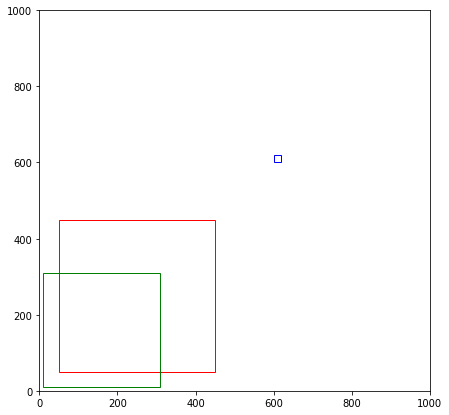

In [153]:
# Plot example boxes
fig, ax = plt.subplots(figsize=(7, 7))
for a, c in zip([a1, a2, a3], ['r', 'g', 'b']):
    rect = patches.Rectangle((a[0],a[1]), a[2], a[3], facecolor='none', edgecolor=c)
    ax.add_patch(rect)
ax.set_xlim(0, 1000); ax.set_ylim(0, 1000);

To compute the intersect and union we first create two new arrays that have the same size as the image. Then we fill the areas inside the boxes with ones.

In [164]:
arr1 = fill_array_with_boxes([a1], img_size)
arr2 = fill_array_with_boxes([a2], img_size)

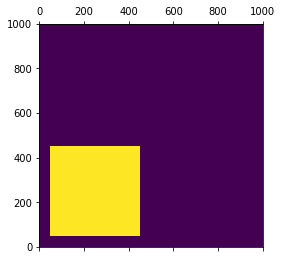

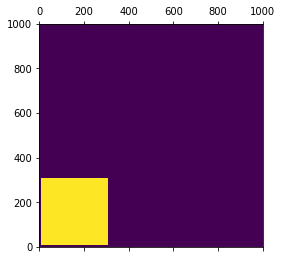

In [167]:
plt.matshow(arr1, origin='lower')
plt.matshow(arr2, origin='lower');

Next, to compute the union, we simply apply the OR operation. Similarly, for the intersect, we apply the AND operation.

In [168]:
intersect = np.bitwise_and(arr1, arr2)
union = np.bitwise_or(arr1, arr2)

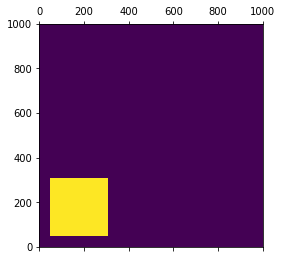

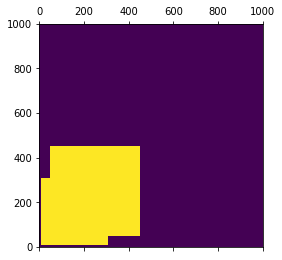

In [169]:
plt.matshow(intersect, origin='lower')
plt.matshow(union, origin='lower');

The last step, is to compute the sum of the intersect and union arrays and divide.

In [170]:
IoU = np.sum(intersect) / np.sum(union); IoU

0.3706140350877193

All these steps are summed up in the following function.

In [171]:
iou.iou_one_class_from_annos([a1], [a2], img_size, return_iou=True)

0.3706140350877193

We can also see what happens in the extreme examples, i.e. complete overlap and no overlap.

In [172]:
iou.iou_one_class_from_annos([a1], [a1], img_size, return_iou=True), \
iou.iou_one_class_from_annos([a1], [a3], img_size, return_iou=True)

(1.0, 0.0)

Further we can see what happens if one side does not have any labels. If this is the case, the IoU will be one. If there are no labels at all, the IoU is undefined. Dividing by zero and so on! Conceptually, though, when both sides do not have labels, the agreement should be perfect, i.e. 1.

In [182]:
iou.iou_one_class_from_annos([a1], [], img_size, return_iou=True), \
iou.iou_one_class_from_annos([], [], img_size, return_iou=True)

/home/s/S.Rasp/repositories/cloud-classification/analysis/pyclouds/iou.py:24: RuntimeWarning: invalid value encountered in long_scalars
  return i/u


(0.0, nan)

## Multi-label IoU

In the cloud classification problem, multiple labels of the same class can be in one image. Using the brute-force array method, this is no problem. 

In [173]:
# Again let's create an example
annos1 = [[0, 0, 300, 300], [500, 500, 200, 200]]
annos2 = [[100, 100, 300, 300], [200, 200, 500, 500], [600, 600, 300, 300]]

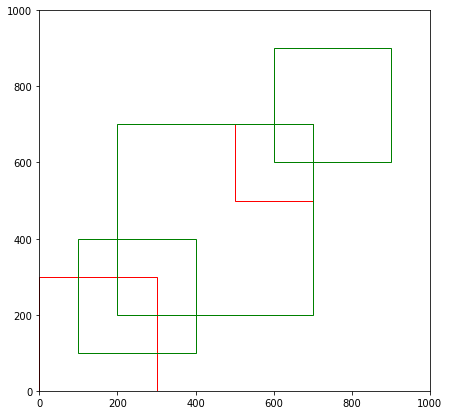

In [174]:
# And plot it
# Plot example boxes
fig, ax = plt.subplots(figsize=(7, 7))
for annos, c in zip([annos1, annos2], ['r', 'g']):
    for a in annos:
        rect = patches.Rectangle((a[0],a[1]), a[2], a[3], facecolor='none', edgecolor=c)
        ax.add_patch(rect)
ax.set_xlim(0, 1000); ax.set_ylim(0, 1000);

In [175]:
arr1 = fill_array_with_boxes(annos1, img_size)
arr2 = fill_array_with_boxes(annos2, img_size)
intersect = np.bitwise_and(arr1, arr2)
union = np.bitwise_or(arr1, arr2)

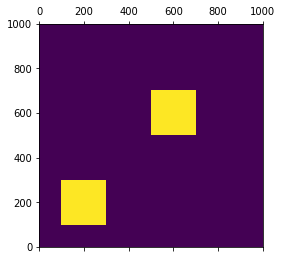

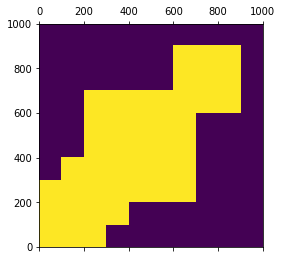

In [176]:
plt.matshow(intersect, origin='lower')
plt.matshow(union, origin='lower');

In [180]:
iou.iou_one_class_from_annos(annos1, annos2, img_size, return_iou=True)

0.18604651162790697

The IoU for one class basically states to which percentage the two labels agree.

## Multi-class IoU

Furthermore, we have several distinct labels. For this now, we would like to compute an average IoU over all classes. For each class, there are three different possibilities:

1. No user has a label for this class.
2. One of the two users has a label for this class.
3. Both users have a label for this class.

What should be done for these cases? What should the IoU for cases 1 and 2 be? And how should they be considered for the averaging? 

Here is one method that I came up with: Sum up the intersects and unions for each class:

1. I = 0, U = 0
2. I = 0, U = Sum of area
3. I and U as computed above.

Then compute the IoU as the fraction of the total I to total U. In the extreme case where both users do not have any labels, the IoU would then be undefined.

In [192]:
# Let's create and example with three classes: 0, 1, 2
classes = [0, 1, 2]
# User 1 has labels for  classes 0 and 1
annos1 = [[[100, 100, 300, 300], 0], [[500, 500, 200, 200], 1]]
# User 2 only has a label for class 0
annos2 = [[[200, 200, 500, 500], 0]]

In [193]:
i_tot = 0; u_tot = 0
for c in classes:
    ac1 = [a[0] for a in annos1 if a[1] == c]
    ac2 = [a[0] for a in annos2 if a[1] == c]
    print(c, ac1, ac2)
    if len(ac1) == 0 and len(ac2) == 0:   # None of the users has this class
        i = 0; u = 0
    elif len(ac1) == 0 or len(ac2) == 0:
        i = 0
        u = iou.compute_area_sum_from_annos(ac1 + ac2)
    else:
        i, u = iou.iou_one_class_from_annos(
                np.array(ac1).astype(np.int32), np.array(ac2).astype(np.int32), img_size)
    print(i, u)
    i_tot += i; u_tot += u

0 [[100, 100, 300, 300]] [[200, 200, 500, 500]]
40000 300000
1 [[500, 500, 200, 200]] []
0 40000
2 [] []
0 0


In [194]:
i_tot, u_tot, i_tot / u_tot

(40000, 340000, 0.11764705882352941)

In [196]:
# This is what is done in the function iou_multi_class
iou.iou_multi_class(annos1, annos2, classes, img_size)

0.11764705882352941

One conceptual problem I have with this is that in case 1, the "agreement" that there is no object of this class in the image is essentially ignored. 

The other option would be to compute one IoU score for each class:

1. IoU = 1
2. IoU = 0
3. IoU = actually compute it

Then take the average for each class. In the extreme case of no labels, the IoU would be 1. However, this method also puts a lot of weight on the classes without labels. We really would like to focus a little more on the classes with labels, I guess!?

In [205]:
def iou_multi_class2(annos1, annos2, classes, img_size, debug=False):
    ious = []
    for c in classes:
        ac1 = [a[0] for a in annos1 if a[1] == c]
        ac2 = [a[0] for a in annos2 if a[1] == c]
        if debug: print(c, ac1, ac2)
        if len(ac1) == 0 and len(ac2) == 0:   # None of the users has this class
            i = 1
        else:
            i = iou.iou_one_class_from_annos(
                np.array(ac1).astype(np.int32), np.array(ac2).astype(np.int32), img_size, return_iou=True)
        ious.append(i)
    if debug: print(ious)
    return np.mean(ious)

In [206]:
iou_multi_class2(annos1, annos2, classes, img_size, True)

0 [[100, 100, 300, 300]] [[200, 200, 500, 500]]
1 [[500, 500, 200, 200]] []
2 [] []
[0.13333333333333333, 0.0, 1]


0.37777777777777777

This naturally results in a much larger score. Let's test this on a few real images to get a good feeling for the scores.

## Some real examples

Lots of prep work at the moment. This should wander into some functions.

In [234]:
from pyclouds.zooniverse import *
from pyclouds.helpers import *

In [209]:
clas_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-classifications_18_12_16.csv'
subj_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'
img_size = (2100, 1400)

In [239]:
classes = ['Sugar', 'Flower', 'Fish', 'Gravel']

In [240]:
subj = load_classifications(subj_fn)

In [242]:
subjects_name = {60811:'BCO_DJF_Aqua',60812:'BCO_DJF_Terra',60813: 'BCO_MAM_Aqua',\
                 60814: 'BCO_MAM_Terra',60815:'R2_DJF_Aqua',60816:'R2_DJF_Terra',\
                 60817:'R3_DJF_Aqua', 60818:'R3_DJF_Terra',60819:'R3_SON_Aqua',\
                 60835: 'R3_SON_Terra'}

In [243]:
subj2fn = {}
for i, r in subj.iterrows():
    if r['subject_set_id'] in list(subjects_name.keys()):
        subj2fn[r['subject_id']] =  r['metadata']['fn']

In [210]:
clas = parse_classifications(clas_fn,json_columns=['metadata', 'annotations', 'subject_data'])

In [290]:
clas['datetime'] = pd.to_datetime(clas['created_at'])

In [291]:
clas_prac = clas[(clas['workflow_name'] == 'Practice') & (clas['datetime'].dt.date == np.datetime64('2018-11-02'))]

In [292]:
clas_prac

classification_id         user_name    user_id               user_ip  \
71             129695770          jkiliani  1837012.0  8009de871f82bf5a6875   
73             129695835         ReinhardB  1837432.0  72f591d5b67421556854   
74             129695837          jkiliani  1837012.0  8009de871f82bf5a6875   
76             129695966          jkiliani  1837012.0  8009de871f82bf5a6875   
78             129696038          jkiliani  1837012.0  8009de871f82bf5a6875   
81             129696124          jkiliani  1837012.0  8009de871f82bf5a6875   
86             129696253         ReinhardB  1837432.0  72f591d5b67421556854   
87             129696294     bjorn.stevens  1825300.0  82d7b927252c67a5e2f8   
100            129696421      TobiasBecker  1836906.0  241b5240ca3687badf8f   
111            129696505       lutz.hirsch  1837010.0  28e5711907d54bd94f66   
119            129696551       lutz.hirsch  1837010.0  28e5711907d54bd94f66   
120            129696559      TobiasBecker  1836906.0  241b5240ca3687badf8f   
126            129696583       lutz.hirsch  1837010.0  28e5711907d54bd94f66   
133            129696626       lutz.hirsch  1837010.0  28e5711907d54bd94f66   
135            129696644       lutz.hirsch  1837010.0  28e5711907d54bd94f66   
143            129696665       lutz.hirsch  1837010.0  28e5711907d54bd94f66   
159            129696769       lutz.hirsch  1837010.0  28e5711907d54bd94f66   
162            129696777       lutz.hirsch  1837010.0  28e5711907d54bd94f66   
167            129696830      TobiasBecker  1836906.0  241b5240ca3687badf8f   
170            129696936   cathyhohenegger  1830046.0  15443b924d281711c5b0   
173            129696990   cathyhohenegger  1830046.0  15443b924d281711c5b0   
175            129697051   cathyhohenegger  1830046.0  15443b924d281711c5b0   
178            129697094   cathyhohenegger  1830046.0  15443b924d281711c5b0   
179            129697100          Uthlande  1836997.0  d7aa4c33d08109dd11d4   
181            129697155   cathyhohenegger  1830046.0  15443b924d281711c5b0   
184            129697235   cathyhohenegger  1830046.0  15443b924d281711c5b0   
185            129697240         jan.welss  1837022.0  e551ecd6265917094e8c   
190            129697308  Julia.Windmiller  1837446.0  44239a31202ce840df73   
191            129697312         jan.welss  1837022.0  e551ecd6265917094e8c   
196            129697340         jan.welss  1837022.0  e551ecd6265917094e8c   
...                  ...               ...        ...                   ...   
8574           129717216       stefankinne  1837454.0  de808832a3a9df1d05a9   
8592           129717270       stefankinne  1837454.0  de808832a3a9df1d05a9   
8616           129717339       stefankinne  1837454.0  de808832a3a9df1d05a9   
8632           129717384       stefankinne  1837454.0  de808832a3a9df1d05a9   
9024           129719588       stefankinne  1837454.0  de808832a3a9df1d05a9   
9042           129719728       stefankinne  1837454.0  de808832a3a9df1d05a9   
9059           129719842       stefankinne  1837454.0  de808832a3a9df1d05a9   
9083           129720017       stefankinne  1837454.0  de808832a3a9df1d05a9   
9108           129720192       stefankinne  1837454.0  de808832a3a9df1d05a9   
9115           129720287       stefankinne  1837454.0  de808832a3a9df1d05a9   
11243          129727627             DelaS  1836251.0  0da0594b79d68c22937d   
11279          129727750             DelaS  1836251.0  0da0594b79d68c22937d   
11319          129727847             DelaS  1836251.0  0da0594b79d68c22937d   
11427          129728115             DelaS  1836251.0  0da0594b79d68c22937d   
11482          129728259             DelaS  1836251.0  0da0594b79d68c22937d   
11522          129728374          tobifinn  1828070.0  2e353d2427b43fe25e4d   
11545          129728440             DelaS  1836251.0  0da0594b79d68c22937d   
11578          129728525          tobifinn  1828070.0  2e353d2427b43fe25e4d   
11591          129728574          tobifinn  1828070.0  2e

In [295]:
annos_prac = annos_from_df(clas_prac, img_size)

In [297]:
subjects_prac = list(annos_prac.keys()); len(subjects_prac)

50

In [298]:
s=subjects_prac[13]

In [307]:
user1 = 'raspstephan'
user2 = 'Julia.Windmiller'

In [303]:
def plot_with_annos(subject_id, annos=annos, users=None):
    fig, ax = plt.subplots(figsize=(15, 10))
    img = Image.open(subj2fn[subject_id])
    ax.imshow(img)
    nones = []
    for a in annos[subject_id]:
        if a[2] is not None:
            if users is not None and a[0] in users:
                coords = a[1]
                rect = patches.Rectangle((coords[0],coords[1]), coords[2], coords[3], facecolor='none', edgecolor='r')
                ax.add_patch(rect)
                ax.text(coords[0],coords[1], a[2] + ' - ' + a[0], color='red', fontsize=15, va='top')
        else:
            nones.append(a[0])
    #if len(nones) > 0:
    #    ax.text(0, -50, 'None: ' + str(nones), color='red', fontsize=15, va='top')

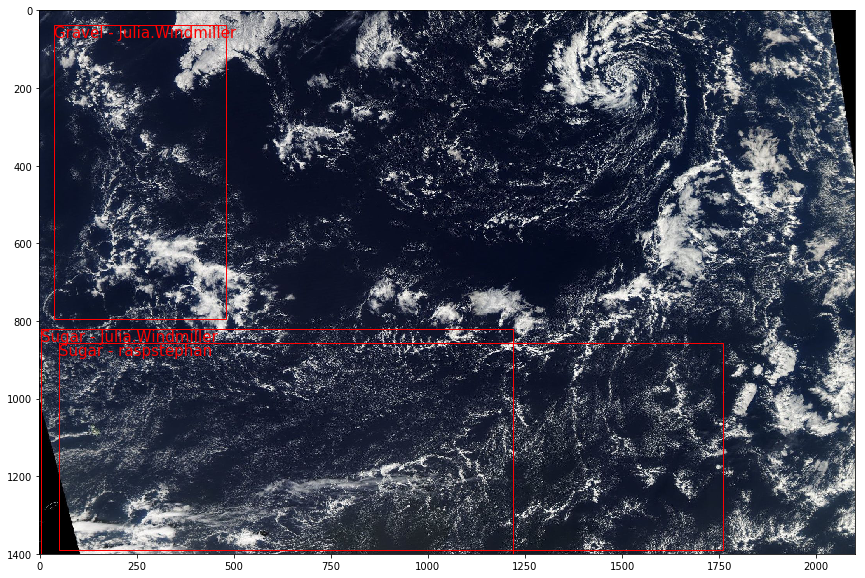

In [308]:
plot_with_annos(s, annos_prac, [user1, user2])

In [313]:
annos_prac[2]

[]

In [314]:
annos1 = [a[1:] for a in annos_prac[s] if a[0] == user1]
annos2 = [a[1:] for a in annos_prac[s] if a[0] == user2]
annos1, annos2

([[[48.96875, 856.0, 1711.0, 535], 'Sugar']],
 [[[4.586301803588867, 820.266357421875, 1213.3249530792236, 579.733642578125],
   'Sugar'],
  [[36.07450866699219,
    37.55143737792969,
    444.32118225097656,
    757.1524200439453],
   'Gravel']])

In [318]:
iou.iou_multi_class(annos1, annos2, classes, img_size)

0.4708014498590415

In [319]:
iou_multi_class2(annos1, annos2, classes, img_size)

Sugar [[48.96875, 856.0, 1711.0, 535]] [[4.586301803588867, 820.266357421875, 1213.3249530792236, 579.733642578125]]
Flower [] []
Fish [] []
Gravel [] [[36.07450866699219, 37.55143737792969, 444.32118225097656, 757.1524200439453]]
[0.6302699695756412, 1, 1, 0.0]


0.6575674923939103

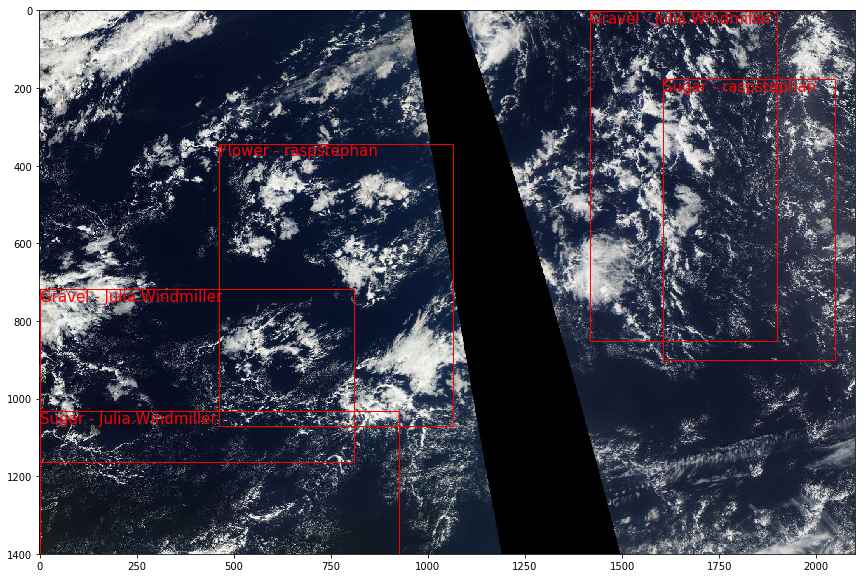

In [323]:
s=subjects_prac[16]
plot_with_annos(s, annos_prac, [user1, user2])

In [324]:
annos1 = [a[1:] for a in annos_prac[s] if a[0] == user1]
annos2 = [a[1:] for a in annos_prac[s] if a[0] == user2]
iou.iou_multi_class(annos1, annos2, classes, img_size), iou_multi_class2(annos1, annos2, classes, img_size)

Sugar [[1604.96875, 176.0, 443.0, 725]] [[0.0, 1031.469482421875, 926.4149932861328, 368.530517578125]]
Flower [[462.96875, 343.0, 602.0, 728]] []
Fish [] []
Gravel [] [[1416.365966796875, 1.3334358930587769, 481.3643798828125, 849.7454215288162], [0.0, 717.7352905273438, 808.5524225234985, 444.65606689453125]]
[0.0, 0.0, 1, 0.0]


(0.0, 0.25)

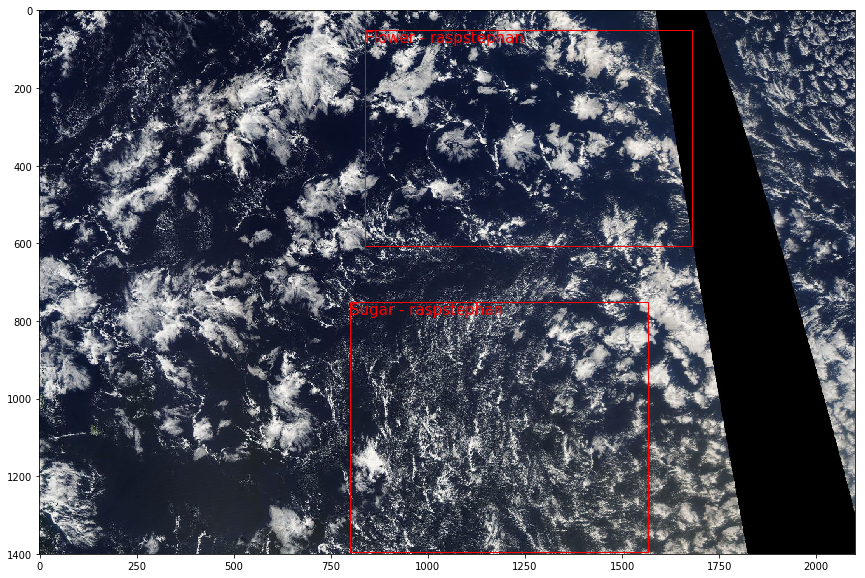

In [325]:
s=subjects_prac[17]
plot_with_annos(s, annos_prac, [user1, user2])

In [326]:
annos1 = [a[1:] for a in annos_prac[s] if a[0] == user1]
annos2 = [a[1:] for a in annos_prac[s] if a[0] == user2]
iou.iou_multi_class(annos1, annos2, classes, img_size), iou_multi_class2(annos1, annos2, classes, img_size)

Sugar [[798.96875, 751.0, 767.0, 643]] []
Flower [[838.96875, 50.0, 841.0, 557]] []
Fish [] []
Gravel [] []
[0.0, 0.0, 1, 1]


(0.0, 0.5)

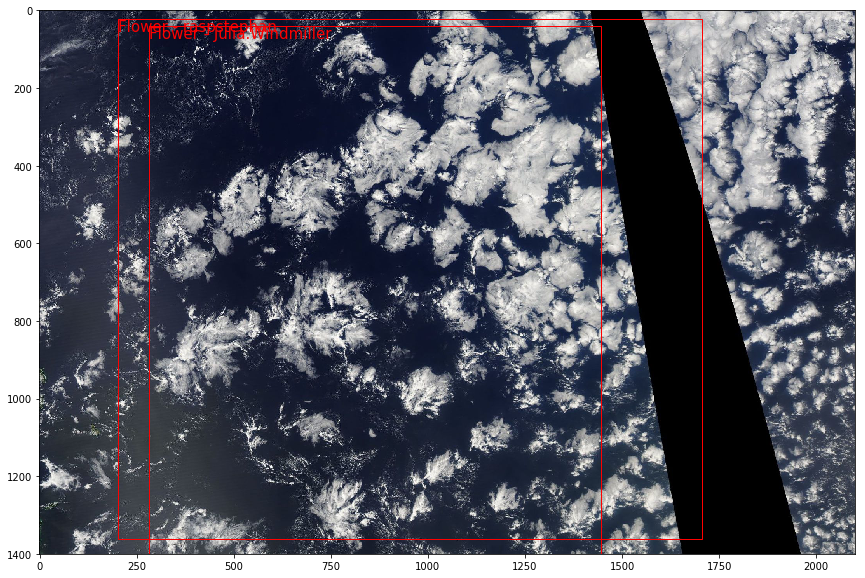

In [331]:
s=subjects_prac[22]
plot_with_annos(s, annos_prac, [user1, user2])

In [332]:
annos1 = [a[1:] for a in annos_prac[s] if a[0] == user1]
annos2 = [a[1:] for a in annos_prac[s] if a[0] == user2]
iou.iou_multi_class(annos1, annos2, classes, img_size), iou_multi_class2(annos1, annos2, classes, img_size)

Sugar [] []
Flower [[202.96875, 22.0, 1503.0, 1340]] [[282.3296203613281, 39.84760665893555, 1162.8876647949219, 1360.1523933410645]]
Fish [] []
Gravel [] []
[1, 0.7473580636787109, 1, 1]


(0.7473580636787109, 0.9368395159196777)

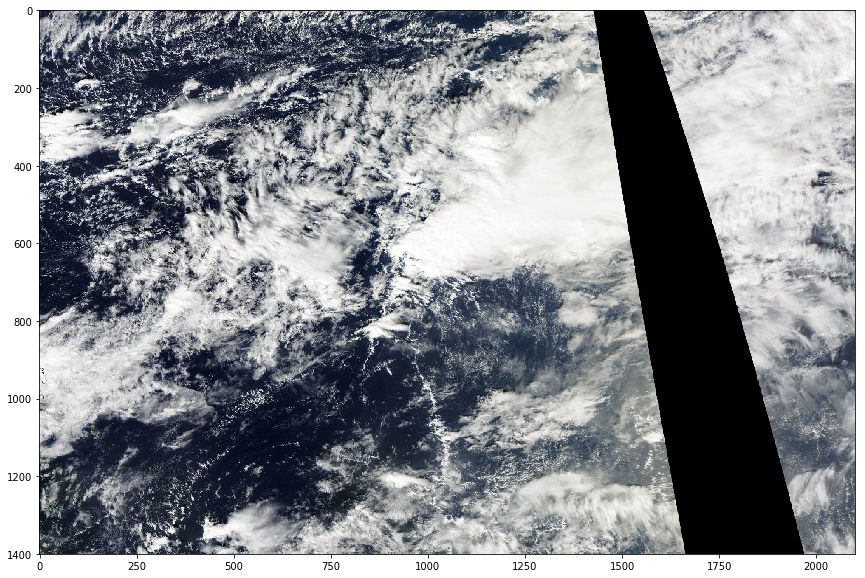

In [359]:
s=subjects_prac[49]
plot_with_annos(s, annos_prac, [user1, user2])

In [363]:
annos1 = [a[1:] for a in annos_prac[s] if a[0] == user1]
annos2 = [a[1:] for a in annos_prac[s] if a[0] == user2]

In [364]:
iou.iou_multi_class(annos1, annos2, classes, img_size)

ZeroDivisionError: division by zero

In [365]:
iou_multi_class2(annos1, annos2, classes, img_size)

Sugar [] []
Flower [] []
Fish [] []
Gravel [] []
[1, 1, 1, 1]


1.0

## How to proceed

So I think both methods have their weaknesses. The question is what do we actually want to do with such a metric. For the multi-class case it becomes very hard to actually interpret the numerical value of the IoU score. This means it would be difficult for people to really understand something about the quantitative agreement. 

If we want to use this score to go on and do some other analysis with it, e.g. cluster people into groups, find out which situations people (dis)agreed upon, then I think it could be valuable. But then we need to figure out how to handle the situations, where only one or none of the users labeled one class. Let's think about it and come back to that.

## Other Metrics

A first goal of ours should be to come up with an **interesting** analysis of how much people agreed on the labels. For this we would like a metric that everyone easily understands. For example, how often did people find the same class in one image (maybe under the condition that they have to overlap a certain area). But again, the question is how to do this in a multi-class setting. Let's also think about this.

Stephan out!

# Old stuff

ignore, will be deleted.

In [154]:
# Compute IoU
# 1. Intersect between two boxes
I = iou.compute_intersect(a1, a2)
# 2. Then compute the sum of the areas and subtract the intersect
U = iou.compute_area_sum([a1, a2]) - I
# Finally, divede I by U
I, U, I/U

(67600, 182400, 0.3706140350877193)

In [155]:
# Test two identical boxes
I = iou.compute_intersect(a1, a1)
U = iou.compute_area_sum([a1, a1]) - I
I/U

1.0

In [156]:
# Test two boxes that do not overlap
I = iou.compute_intersect(a1, a3)
U = iou.compute_area_sum([a1, a3]) - I
I/U

0.0

## A different way of computing IoU - the brute force way

The method above works great in simple cases. Going to the multi-label case however is really tricky because a lot of special cases have to be considered, such as overlapping boxes of one or both users. I think it is possible just using the box edge coordinates but I struggled for too long. 

So we will just use the brute force approach. We will simply create an array with the same dimensions as the image and fill in the boxes.

In [157]:
def fill_array_with_boxes(annos, img_size):
    """
    Creates an array where all areas of the array that are in one of the boxes are True, otherwise False
    """
    arr = np.zeros(img_size, dtype=bool)
    for a in annos:
        arr[a[0]:a[0]+a[2], a[1]:a[1]+a[3]] = True
    return arr

In [158]:
def intersect_from_arrs(arr1, arr2):
    return np.sum(np.bitwise_and(arr1, arr2))
def union_from_arrs(arr1, arr2):
    return np.sum(np.bitwise_or(arr1, arr2))
def iou_one_class_from_arrs(arr1, arr2):
    return intersect_from_arrs(arr1, arr2) / union_from_arrs(arr1, arr2)
def iou_one_class_from_annos(annos1, annos2, img_size):
    return iou_one_class_from_arrs(
        fill_array_with_boxes(annos1, img_size), fill_array_with_boxes(annos2, img_size))

In [161]:
iou_one_class_from_annos([a1], [a2], (1000, 1000)), \
iou_one_class_from_annos([a1], [a1], (1000, 1000)), \
iou_one_class_from_annos([a1], [a3], (1000, 1000))

(0.3706140350877193, 1.0, 0.0)

## Multi-label case

Next we will simulate the case where the two "users" draw several boxes. For now let's assume that there is only one class.

In [71]:
# Again let's create an example
annos1 = [[0, 0, 3, 3], [5, 5, 2, 2]]
annos2 = [[1, 1, 3, 3], [2, 2, 5, 5], [6, 6, 3, 3]]
# Easy example 1: I = 12, U = 37
annos1 = [[0, 0, 4, 4], [3, 3, 3, 3]]   # For only annos1: I = U = 24
annos2 = [[2, 2, 5, 5]]

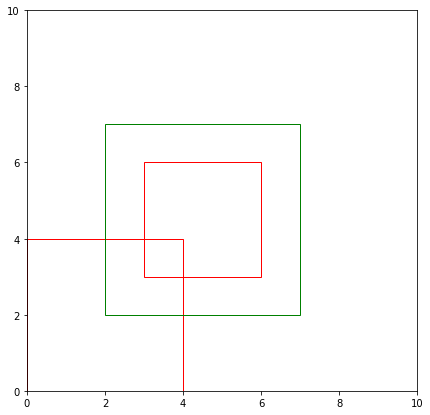

In [72]:
# And plot it
# Plot example boxes
fig, ax = plt.subplots(figsize=(7, 7))
for annos, c in zip([annos1, annos2], ['r', 'g']):
    for a in annos:
        rect = patches.Rectangle((a[0],a[1]), a[2], a[3], facecolor='none', edgecolor=c)
        ax.add_patch(rect)
ax.set_xlim(0, 10); ax.set_ylim(0, 10);

Here it becomes a bigger challenge to compute the intersect and union.

First we 

In [131]:
annos1

[[0, 0, 4, 4], [3, 3, 3, 3]]

In [147]:
z1 = np.zeros((10, 10), dtype=bool)
for a in annos1:
    z1[a[0]:a[0]+a[2], a[1]:a[1]+a[3]] = True
z2 = np.zeros((10, 10), dtype=bool)
for a in annos1:
    z2[a[0]:a[0]+a[2], a[1]:a[1]+a[3]] = True
z_i = np.bitwise_and(z1, z2)
z_u = np.bitwise_or(z1, z2)
np.sum(z_i), np.sum(z_u)

(24, 24)

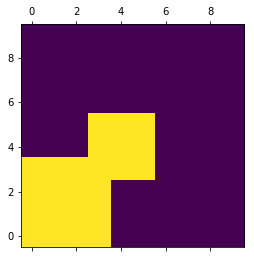

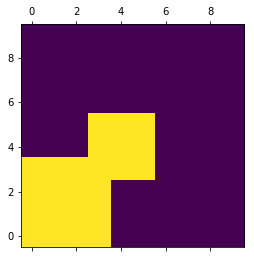

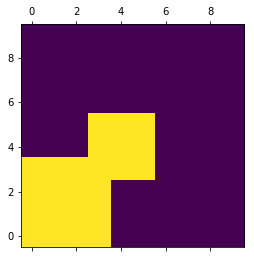

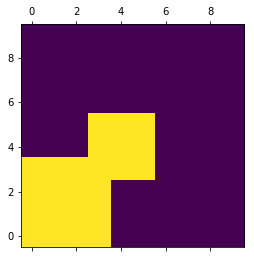

In [148]:
plt.matshow(z1, origin='lower')
plt.matshow(z2, origin='lower')
plt.matshow(z_i, origin='lower')
plt.matshow(z_u, origin='lower')

In [106]:
def wh2xy(x, y, w, h):
    return x, y, x+w, y+h

def compute_intersect_tmp(a1, a2):
    """
    https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    Computes the intersect between two boxes.
    """
    x1a, y1a, x2a, y2a = wh2xy(*a1)
    x1b, y1b, x2b, y2b = wh2xy(*a2)
    xA = max(x1a, x1b)
    yA = max(y1a, y1b)
    xB = min(x2a, x2b)
    yB = min(y2a, y2b)
    i = max(0, xB - xA) * max(0, yB - yA) # max(0, xB - xA + 1) * max(0, yB - yA + 1)
    return i, [xA, yA, xB, yB]

In [101]:
compute_intersect_tmp(annos1[0], annos1[0]), annos1[0]

((16, 0, 0, 4, 4), [0, 0, 4, 4])

In [117]:
def wh2xy(x, y, w, h):
    return x, y, x+w, y+h

def xy2wh(x1, y1, x2, y2):
    return x1, y1, x2 - x1, y2 - y1

In [121]:
i = 0
intersects = []
for a1 in annos1:
    for a2 in annos1:
        r = compute_intersect_tmp(a1, a2)
        i += r[0]
        intersects.append(xy2wh(*r[1]))

In [122]:
i

27

In [123]:
intersects

[(0, 0, 4, 4), (3, 3, 1, 1), (3, 3, 1, 1), (3, 3, 3, 3)]

In [130]:
ii = 0
for i1, i2 in itertools.combinations(intersects, 2):
    print(i1, i2, compute_intersect(i1, i2))
    ii += compute_intersect(i1, i2)
ii, ii // 2

(0, 0, 4, 4) (3, 3, 1, 1) 1
(0, 0, 4, 4) (3, 3, 1, 1) 1
(0, 0, 4, 4) (3, 3, 3, 3) 1
(3, 3, 1, 1) (3, 3, 1, 1) 1
(3, 3, 1, 1) (3, 3, 3, 3) 1
(3, 3, 1, 1) (3, 3, 3, 3) 1


(6, 3)

In [129]:
for i1, i2 in itertools.combinations([0, 1, 2, 3], 2):
    print(i1, i2)

0 1
0 2
0 3
1 2
1 3
2 3


In [89]:
from pyclouds.iou import compute_intersect, compute_area_sum
import pdb
def iou_one_class_tmp(annos1, annos2):
    pdb.set_trace()
    """annos1 and annos2 are lists with the coordinates of each annotation"""
    # All permutations
    i_tmp = 0
    for a1 in annos1:
        for a2 in annos2:
            i_tmp += compute_intersect(a1, a2)
    # Need to compute the overlap between the boxes of 1 and 2
    i1 = 0; i2 = 0
    for b1, b2 in itertools.combinations(annos1, 2):
        i1 += compute_intersect(b1, b2)
    for b1, b2 in itertools.combinations(annos2, 2):
        i2 += compute_intersect(b1, b2)
        
    i = i_tmp - i1 - i2
    i3 = 0
    for b1, b2 in itertools.combinations(annos1 + annos2, 2):
        i3 += compute_intersect(b1, b2)
    u = compute_area_sum(annos1 + annos2) - i_tmp #- i3
    
    iou = i/u  #(i - i1 - i2) / u
    return i, u, iou

In [90]:
i, u = iou.iou_one_class(annos1, annos1)
i, u, i/u, iou_one_class_tmp(annos1, annos1)

> <ipython-input-89-7f1e2b7d51db>(7)iou_one_class_tmp()
-> i_tmp = 0
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(8)iou_one_class_tmp()
-> for a1 in annos1:
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(9)iou_one_class_tmp()
-> for a2 in annos2:
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(10)iou_one_class_tmp()
-> i_tmp += compute_intersect(a1, a2)
(Pdb) p a1, a2
([0, 0, 4, 4], [0, 0, 4, 4])
(Pdb) compute_intersect(a1, a2)
16
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(9)iou_one_class_tmp()
-> for a2 in annos2:
(Pdb) i_tmp
16
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(10)iou_one_class_tmp()
-> i_tmp += compute_intersect(a1, a2)
(Pdb) p a1, a2
([0, 0, 4, 4], [3, 3, 3, 3])
(Pdb) compute_intersect(a1, a2)
1
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(9)iou_one_class_tmp()
-> for a2 in annos2:
(Pdb) i_tmp
17
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(8)iou_one_class_tmp()
-> for a1 in annos1:
(Pdb) n
> <ipython-input-89-7f1e2b7d51db>(9)iou_one_class_tmp()
-> for a2 in annos2:
(Pdb) n
> <ipython-input-89-

BdbQuit: 